# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

Optionally, uninstall the ws3 package and replace it with a pointer to this local clone of the GitHub repository code (useful if you want ot tweak the source code for whatever reason).

## Set up Modelling Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import ws3 Module from Local Server
import ws3
#Show Module Path
ws3.__path__

['/media/data/project/yyan/tmp/ws3/examples/ws3']

In [3]:
# Install ws3 Module from GitHub and Import it
# install_ws3 = True
# install_ws3_localeditable = None
# if install_ws3:
#     if install_ws3_localeditable: # clobber ws3 installation with local editable copy
#         %pip uninstall -y ws3
#         %pip install -e ..
#     else: # install dev_libcbm branch from ws3 GitHub repo
#         %pip install -U git+https://github.com/gparadis/ws3@dev_libcbm
#     import ws3
#     ws3.__path__

In [4]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

## Create and Run `ForestModel` instance

In [5]:
# Install Pandas Library Version 2.0.3
%pip install pandas==2.0.3

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time

In [7]:
#Start Calculating the Running Time
Start = time.time()

In [8]:
# Set Basic Parameters
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [9]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_tsa24',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [10]:
# Import Modules
from util import compile_scenario, plot_scenario

(<Figure size 1200x400 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Harvested area (ha)'}>,
        <AxesSubplot:title={'center':'Harvested volume (m3)'}>,
        <AxesSubplot:title={'center':'Growing Stock (m3)'}>,
        <AxesSubplot:title={'center':'Ecosystem C stock (tons)'}>,
        <AxesSubplot:title={'center':'Total Carbon Emission (tons)'}>],
       dtype=object))

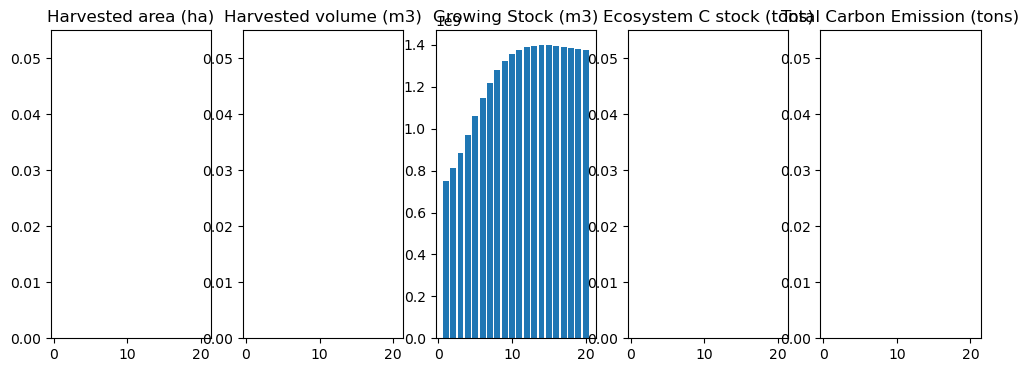

In [11]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

In [12]:
# Import Modules
import libcbm
from util import run_cbm, cbm_report, plugin_c_curves, compare_ws3_cbm

Prepare CBM input files

In [13]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
# Define Sit_config File
sit_config = {
                'mapping_config': {
                    'nonforest': None,
                    'species': {
                        'species_classifier': 'species',
                        'species_mapping': [
                            {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                            {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
                        ]
                    },
                    'spatial_units': {
                        'mapping_mode': 'SingleDefaultSpatialUnit',
                        'admin_boundary': 'British Columbia',
                        'eco_boundary': 'Montane Cordillera'},
                    'disturbance_types': {
                        'disturbance_type_mapping': disturbance_type_mapping
                    }
                }
            }

In [15]:
# Define Sit Files
sit_classifiers = pd.read_csv('data/libcbm_model_files_tsa24/sit_classifiers.csv')
sit_disturbance_types = pd.read_csv('data/libcbm_model_files_tsa24/sit_disturbance_types.csv')
sit_age_classes = pd.read_csv('data/libcbm_model_files_tsa24/sit_age_classes.csv')
sit_inventory = pd.read_csv('data/libcbm_model_files_tsa24/sit_inventory.csv')
sit_yield = pd.read_csv('data/libcbm_model_files_tsa24/sit_yield.csv')
sit_events = pd.read_csv('data/libcbm_model_files_tsa24/sit_events.csv')
sit_transitions = pd.read_csv('data/libcbm_model_files_tsa24/sit_transitions.csv')

In [16]:
# Define Sit Tables
sit_tables = {'sit_classifiers': sit_classifiers,
              'sit_disturbance_types': sit_disturbance_types,
              'sit_age_classes': sit_age_classes,
              'sit_inventory': sit_inventory,
              'sit_yield': sit_yield,
              'sit_events': sit_events,
              'sit_transitions': sit_transitions}

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [17]:
# self = fm
# sit_tables = {'sit_classifiers':self._cbm_sit_classifiers(),
#               'sit_disturbance_types':self._cbm_sit_disturbance_types(),
#               'sit_age_classes':self._cbm_sit_age_classes(),
#               'sit_inventory':self._cbm_sit_inventory(softwood_volume_yname='swdvol', 
#                                                       hardwood_volume_yname='hwdvol'),
#               'sit_yield':self._cbm_sit_yield(softwood_volume_yname='swdvol', 
#                                               hardwood_volume_yname='hwdvol', n_yield_vals=100),
#               'sit_events':self._cbm_sit_events(),
#               'sit_transitions':self._cbm_sit_transitions()}

In [18]:
# self = fm
# sit_config, sit_tables = self.to_cbm_sit(softwood_volume_yname='swdvol', 
#                                          hardwood_volume_yname='hwdvol', 
#                                          admin_boundary='British Columbia', 
#                                          eco_boundary='Montane Cordillera',
#                                          disturbance_type_mapping=disturbance_type_mapping)

In [19]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [20]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [21]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [22]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes

sum_pools = ['ecosystem', 'biomass', 'DOM']

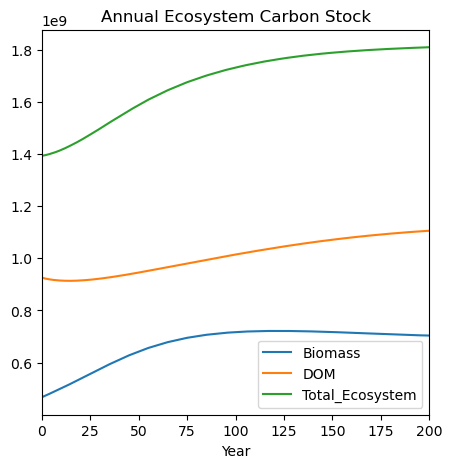

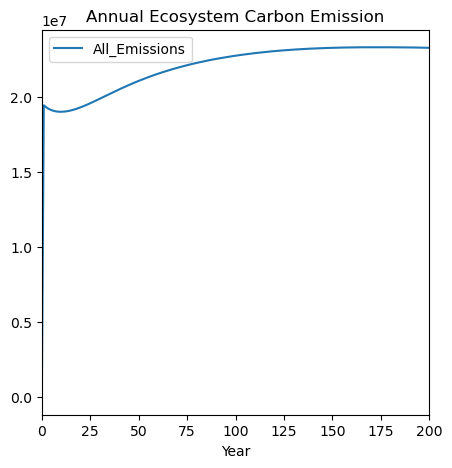

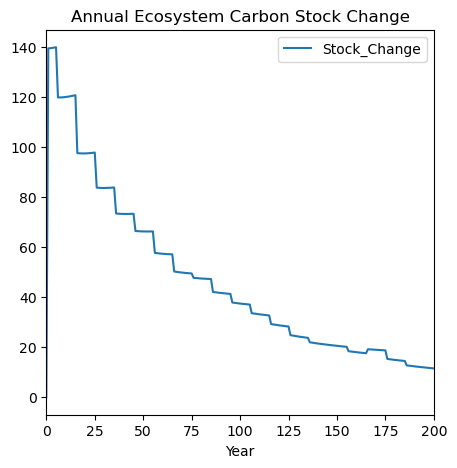

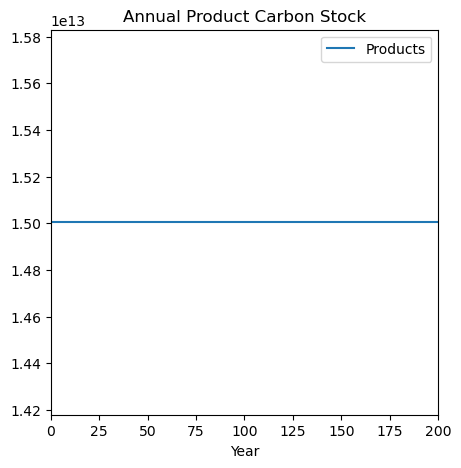

In [23]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [24]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [25]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,False,5,345.7,0,0,fire,fire
1,tsa24,0,2401000,100,2401000,softwood,False,15,825.8,0,0,fire,fire
2,tsa24,0,2401000,100,2401000,softwood,False,25,1611.1,0,0,fire,fire
3,tsa24,0,2401000,100,2401000,softwood,False,35,1508.5,0,0,fire,fire
4,tsa24,0,2401000,100,2401000,softwood,False,45,264.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,tsa24,1,2403007,100,2423007,softwood,False,25,7712.3,0,0,fire,harvest
766,tsa24,1,2403007,100,2423007,softwood,False,35,15703.9,0,0,fire,harvest
767,tsa24,1,2403007,100,2423007,softwood,False,45,11587.8,0,0,fire,harvest
768,tsa24,1,2403007,100,2423007,softwood,False,55,6871.6,0,0,fire,harvest


In [26]:
# Set Age and Area to 0 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [27]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,False,0,1.0,0,0,fire,fire
1,tsa24,0,2401001,304,2401001,softwood,False,0,1.0,0,0,fire,fire
2,tsa24,0,2401003,304,2401003,softwood,False,0,1.0,0,0,fire,fire
3,tsa24,0,2401004,104,2401004,softwood,False,0,1.0,0,0,fire,fire
4,tsa24,0,2401005,1201,2401005,hardwood,False,0,1.0,0,0,fire,fire
5,tsa24,0,2401006,1201,2401006,hardwood,False,0,1.0,0,0,fire,fire
6,tsa24,0,2402001,304,2402001,softwood,False,0,1.0,0,0,fire,fire
7,tsa24,0,2402005,1201,2402005,hardwood,False,0,1.0,0,0,fire,fire
8,tsa24,0,2402006,1201,2402006,hardwood,False,0,1.0,0,0,fire,fire
9,tsa24,0,2403005,1201,2403005,hardwood,False,0,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [28]:
# df_sub = df.loc[(df['theme1'] == 1) & (df['last_pass_disturbance'] == 'fire')]
# df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
# df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')
# df_sub
# df = pd.concat([df, df_sub], ignore_index=True)
# df = df.drop_duplicates(ignore_index=True)
# df

In [29]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [30]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [31]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [32]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24,0,2401000,100,2401000,softwood,1.0,0.000000,...,74.016010,52.671391,23.112688,0.000000,0.000000,5878.431742,6.068142,54.611643,0.0,0.000000
1,2,0,tsa24,0,2401001,304,2401001,softwood,1.0,0.000000,...,44.921289,27.501144,19.287436,0.000000,0.000000,3613.528216,4.476831,40.290231,0.0,0.000000
2,3,0,tsa24,0,2401003,304,2401003,softwood,1.0,0.000000,...,70.049220,62.438897,24.551759,0.000000,0.000000,5650.351208,6.311380,56.800795,0.0,0.000000
3,4,0,tsa24,0,2401004,104,2401004,softwood,1.0,0.000000,...,53.956053,44.779207,21.934440,0.000000,0.000000,4365.512943,5.270469,47.432810,0.0,0.000000
4,5,0,tsa24,0,2401005,1201,2401005,hardwood,1.0,0.000000,...,127.289305,0.000000,0.000000,102.657634,21.803018,10841.470933,9.787445,88.084688,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7432,33,200,tsa24,1,2403003,304,2423003,softwood,1.0,95.609403,...,94.058717,9.559927,2.290215,0.000000,0.000000,7339.963239,6.855230,61.695426,0.0,72.563607
7433,34,200,tsa24,1,2403004,104,2403004,softwood,1.0,62.438897,...,73.407698,6.163382,1.917804,0.000000,0.000000,6049.629521,5.988370,53.893744,0.0,0.000000
7434,35,200,tsa24,1,2403004,104,2423004,softwood,1.0,75.781025,...,74.672467,7.263171,2.059984,0.000000,0.000000,5721.036242,5.630286,50.671138,0.0,51.700860
7435,36,200,tsa24,1,2403007,100,2403007,softwood,1.0,84.785477,...,107.130573,11.198718,2.231945,0.000000,0.000000,9047.847670,8.065668,72.589057,0.0,0.000000


In [33]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,DisturbanceCO2Production,DisturbanceCH4Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa24,0,2401000,100,2401000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa24,0,2401001,304,2401001,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa24,0,2401003,304,2401003,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa24,0,2401004,104,2401004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa24,0,2401005,1201,2401005,hardwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7432,33,200,tsa24,1,2403003,304,2423003,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7433,34,200,tsa24,1,2403004,104,2403004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7434,35,200,tsa24,1,2403004,104,2423004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7435,36,200,tsa24,1,2403007,100,2403007,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [35]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [36]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0              0.000000         0.000000   
                            1              0.000100         0.142072   
                            2              0.000803         0.399931   
                            3              0.002724         0.575965   
                            4              0.006477         0.742157   
...                                             ...              ...   
tsa24 1 2403007 100 2423007 196          110.554996         9.315055   
                            197          110.630710         9.317758   
                            198          110.706420         9.320459   
                            199          110.782125         9.323159   
                            200          110.857825         9.325857   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 0 2401000 100 2401000 0              0.000000             0.000000   
                            1              0.000000             0.018159   
                            2              0.009712             0.052654   
                            3              0.182878             0.098251   
                            4              0.430046             0.153070   
...                                             ...                  ...   
tsa24 1 2403007 100 2423007 196           35.077570            31.728258   
                            197           35.089584            31.747243   
                            198           35.101597            31.766226   
                            199           35.113608            31.785206   
                            200           35.125619            31.804184   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 0 2401000 100 2401000 0                  0.000000            0.0   
                            1                  0.013403            0.0   
                            2                  0.038465            0.0   
                            3                  0.070817            0.0   
                            4                  0.108597            0.0   
...                                                 ...            ...   
tsa24 1 2403007 100 2423007 196                2.670114            0.0   
                            197                2.671205            0.0   
                            198                2.672296            0.0   
                            199                2.673388            0.0   
                            200                2.674481            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
tsa24 1 2403007 100 2423007 196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 0 2401000 100 2401000 0                       

In [37]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 0 2401000 100 2401000 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
tsa24 1 2403007 100 2423007 196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   

In [38]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [39]:
# Generate carbon yield curves for net emission
c_curves_f['total_emissions'] = c_curves_f[fluxes].sum(axis=1)
c_curves_f['net_fluxes'] = c_curves_f[npp_fluxes+["TurnoverMerchLitterInput","TurnoverFolLitterInput","TurnoverOthLitterInput","TurnoverCoarseLitterInput","TurnoverFineLitterInput"]].sum(axis=1)-c_curves_f[decay_emissions_fluxes].sum(axis=1)

In [40]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0              0.000000         0.000000   
                            1              0.000100         0.142072   
                            2              0.000803         0.399931   
                            3              0.002724         0.575965   
                            4              0.006477         0.742157   
...                                             ...              ...   
tsa24 1 2403007 100 2423007 196          110.554996         9.315055   
                            197          110.630710         9.317758   
                            198          110.706420         9.320459   
                            199          110.782125         9.323159   
                            200          110.857825         9.325857   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 0 2401000 100 2401000 0              0.000000             0.000000   
                            1              0.000000             0.018159   
                            2              0.009712             0.052654   
                            3              0.182878             0.098251   
                            4              0.430046             0.153070   
...                                             ...                  ...   
tsa24 1 2403007 100 2423007 196           35.077570            31.728258   
                            197           35.089584            31.747243   
                            198           35.101597            31.766226   
                            199           35.113608            31.785206   
                            200           35.125619            31.804184   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 0 2401000 100 2401000 0                  0.000000            0.0   
                            1                  0.013403            0.0   
                            2                  0.038465            0.0   
                            3                  0.070817            0.0   
                            4                  0.108597            0.0   
...                                                 ...            ...   
tsa24 1 2403007 100 2423007 196                2.670114            0.0   
                            197                2.671205            0.0   
                            198                2.672296            0.0   
                            199                2.673388            0.0   
                            200                2.674481            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
tsa24 1 2403007 100 2423007 196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 0 2401000 100 2401000 0                       

In [41]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 0 2401000 100 2401000 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
tsa24 1 2403007 100 2423007 196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   

Curvs Calibration

In [42]:
# c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
# c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

In [43]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0              0.000000         0.000000   
                            1              0.000100         0.142072   
                            2              0.000803         0.399931   
                            3              0.002724         0.575965   
                            4              0.006477         0.742157   
...                                             ...              ...   
tsa24 1 2403007 100 2423007 196          110.554996         9.315055   
                            197          110.630710         9.317758   
                            198          110.706420         9.320459   
                            199          110.782125         9.323159   
                            200          110.857825         9.325857   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 0 2401000 100 2401000 0              0.000000             0.000000   
                            1              0.000000             0.018159   
                            2              0.009712             0.052654   
                            3              0.182878             0.098251   
                            4              0.430046             0.153070   
...                                             ...                  ...   
tsa24 1 2403007 100 2423007 196           35.077570            31.728258   
                            197           35.089584            31.747243   
                            198           35.101597            31.766226   
                            199           35.113608            31.785206   
                            200           35.125619            31.804184   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 0 2401000 100 2401000 0                  0.000000            0.0   
                            1                  0.013403            0.0   
                            2                  0.038465            0.0   
                            3                  0.070817            0.0   
                            4                  0.108597            0.0   
...                                                 ...            ...   
tsa24 1 2403007 100 2423007 196                2.670114            0.0   
                            197                2.671205            0.0   
                            198                2.672296            0.0   
                            199                2.673388            0.0   
                            200                2.674481            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
tsa24 1 2403007 100 2423007 196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 0 2401000 100 2401000 0                       

In [44]:
# Check the total ecosystem stock change
c_curves_p['ecosystem'].diff()

dtype_key                    timestep
tsa24 0 2401000 100 2401000  0                NaN
                             1          -3.960478
                             2          -3.496429
                             3          -3.124339
                             4          -2.806476
                                           ...   
tsa24 1 2403007 100 2423007  196         0.400119
                             197         0.398257
                             198         0.396461
                             199         0.394727
                             200         0.393047
Name: ecosystem, Length: 7437, dtype: float64

In [45]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 0 2401000 100 2401000 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
tsa24 1 2403007 100 2423007 196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [46]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402006', '?', '2402006

In [47]:
# Check if all carbon yield curves are plugged in well.
# fm.yields

## Implement Optimization-based Action Scheduling

In [48]:
#Install Module
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [49]:
#Import Module
import gurobipy as grb

In [50]:
#Import Module
# from util import cmp_c_z,cmp_c_cflw,cmp_c_caa,cmp_c_ci,gen_scenario

Add a "null" action to the model for the optimization functions to work correctly.

In [51]:
#Add a Null Action
fm.add_null_action()

Define base and other scenarios below. You can change you objective functions and constraints by modifying the scenarios directly.

In [71]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
            # print('is harvested')
            # print(result)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

In [87]:
# Define Objective Function for carbon indicators
def cmp_c_i(fm, path, yname, mask=None): # product, named actions
    """
    Compile objective function coefficient for inventory indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        # print(t)
        # print(n)
        # print(d)
        if mask and not fm.match_mask(mask, d['dtk']): continue
        result += fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']])
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
    return result


import math

def cmp_c_ss(fm, path, expr, mask=None, yname=None):
    """
    Compile objective function coefficient for total system carbon storage indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / 30  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / 2  # Decay rate for paper (2-year half-life)
    
    product_stock_dict = {}  # Dictionary to track product stock for each node across iterations

    for t, n in enumerate(path, start=1):

        d = n.data()
        node_id = id(n)  # or another unique identifier specific to your application

        # Retrieve the last tuple of stocks from the dictionary
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks

        if mask and not fm.match_mask(mask, d['_dtk']): continue
        if fm.is_harvest(d['acode']):
            # Calculate new product stock assuming 50% goes into solid wood and 50% into paper
            new_product_mass = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
            new_product_stock_solid_wood = new_product_mass * 0.5 * 460 * 0.5 / 1000
            new_product_stock_paper = new_product_mass * 0.5 * 460 * 0.5 / 1000

            # Apply decay to old stocks and add new stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood) + new_product_stock_solid_wood * (1 - k_solid_wood)
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper) + new_product_stock_paper * (1 - k_paper)

            # Update product_stock_dict with the new sum product stocks for this node
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)
            
            sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper
            result += sum_product_stock
        
        else:
            # If not harvesting, simply apply decay to the old product stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)

            sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper
            result += sum_product_stock
            
        # Add to result the inventory plus the current product stocks for the node
        result += fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']])

    return result

# def cmp_c_se(fm, path, expr, mask=None, yname=None):
#     """
#     Compile objective function coefficient for total system carbon storage indicators (given ForestModel instance, 
#     leaf-to-root-node path, and expression to evaluate).
#     """
#     result = 0.
#     # Calculate decay rates based on half-lives
#     k_solid_wood = math.log(2) / 30  # Decay rate for solid wood products (30-year half-life)
#     k_paper = math.log(2) / 2  # Decay rate for paper (2-year half-life)
#     product_stock_dict = {}  # Dictionary to track product stock for each node across iterations

#     for t, n in enumerate(path, start=1):
#         d = n.data()
#         if mask and not fm.match_mask(mask, d['dtk']): continue

#         node_id = id(n)  # or another unique identifier specific to your application

#         # Initialize old product stocks for both product types from product_stock_dict or set to 0 if not present
#         old_product_stock_solid_wood, old_product_stock_paper = product_stock_dict.get(node_id, (0, 0))

#         if fm.is_harvest(d['acode']):
#             # Calculate new product stock assuming 50% goes into solid wood and 50% into paper
#             new_product_mass = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
#             new_product_stock_solid_wood = new_product_mass * 0.5 * 460 * 0.5 / 1000
#             new_product_stock_paper = new_product_mass * 0.5 * 460 * 0.5 / 1000

#             # Apply decay to old stocks and add new stocks
#             sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood) + new_product_stock_solid_wood * (1 - k_solid_wood)
#             sum_product_stock_paper = old_product_stock_paper * (1 - k_paper) + new_product_stock_paper * (1 - k_solid_wood)

#             # Update product_stock_dict with the new sum product stocks for this node
#             product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)
#         else:
#             # If not harvesting, simply apply decay to the old product stocks
#             sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)
#             sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)
#             product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)
            
#         sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper

#         # Add to result the inventory plus the current product stocks for the node
#         result += fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']])
#         result += sum_product_stock  # Add the sum of current product stocks (solid wood and paper)

#     return result

# def cmp_c_sc(fm, path, expr):
#     """
#     Compile objective function coefficient for total system carbon storage indicators (given ForestModel instance, 
#     leaf-to-root-node path, and expression to evaluate).
#     """
#     result = 0.
#     k = 0.2 #k is decay rate
#     for t, n in enumerate(path, start=1):
#         d = n.data()
#         if mask and not fm.match_mask(mask, d['dtk']): continue
#         if fm.is_harvest(d['acode']):
#             old_product_stock = d['products']*(1-k)
#             new_product_stock = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * 460 * 0.5 * (1-k) / 1000 # calcuate the HWPs carbon storage (tons of C)
#             sum_product_stock = old_product_stock + new_product_stock
#             result += fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) # calcuate the forest ecosystem carbon storage (tons of C)
#             result += sum_product_stock
#     return result

In [88]:
#Define the objective function for the total ecosystem carbon storage

# def cmp_c_ct(fm, path, yname, expr, mask=None):
#     """
#     Calculate the total system carbon storage, including the carbon stored in the forest ecosystem and
#     in the harvested wood, considering individual decay for each harvested batch.
#     """
#     harvests = []  # List to store tuples of (carbon stored, time harvested)
#     result = 0.0   # Total system carbon storage (forest ecosystem + harvested wood)
#     decay_factor = (1/2)**(1/100)  # Decay to 1/2 every 40 years, calculated every 10 years
    
#     for t, n in enumerate(path, start=1):
#         d = n.data()
#         if mask and not fm.match_mask(mask, d['dtk']):
#             continue
        
#         # Apply decay to each previously stored harvest based on the time mi elapsed
#         for i in range(len(harvests)):
#             time_elapsed = t - harvests[i][1]  # Current time period minus the time of harvest
#             decayed_carbon = harvests[i][0] * (decay_factor ** time_elapsed)
#             harvests[i] = (decayed_carbon, harvests[i][1])
        
#         # Calculate and add new harvest
#         new_harvest_carbon = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * 460 * 0.5 * 44
#         harvests.append((new_harvest_carbon, t))  # Add new harvest with the current time period

#         # Calculate total carbon stored in harvested wood
#         total_harvest_carbon = sum(harvest[0] for harvest in harvests)

#         # Calculate total carbon stored in the forest ecosystem
#         total_ecosystem_carbon = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
        
#         # Calculate total system carbon storage
#         result += (total_ecosystem_carbon + total_harvest_carbon)

#     return result

Test if the product carbon is calculated correctly

In [89]:
# harvests = [(100,1), (100,2), (100,3), (100,4)]  # List to store tuples of (carbon stored, time harvested)
# result = 0.0   # Total system carbon storage (forest ecosystem + harvested wood)
# decay_factor = (1/2)**(1/4)  # Decay to 1/2 every 40 years, calculated every 10 years

# # Apply decay to each previously stored harvest based on the time elapsed
# for i in range(len(harvests)):
#     time_elapsed = 5 - harvests[i][1]  # Current time period minus the time of harvest
#     decayed_carbon = harvests[i][0] * (decay_factor ** time_elapsed)
#     harvests[i] = (decayed_carbon, harvests[i][1])
    
#     print(time_elapsed)
#     print(decayed_carbon)

# total_harvest_carbon = sum(harvest[0] for harvest in harvests)
# total_harvest_carbon

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem. I left some notes below (and some comments in the `_gen_scen_base` function code) to help clarify the expected arg structure, and will work on expanding the docstrings in the `ws3` source code so this is less obscure going forward.

I also had to patch the `ws3` code in two places so that it would "grow" correctly with the model set up to use _years_ as the age unit. For some reason the latest `dev` branch of `ws3` on GitHub was in some sort of intermediate state between using _periods_ and _years_ as the age unit. Originally `ws3` was implemented to import and simulate legacy Woodstock model input datasets, so it used _periods_ as the age unit (like Woodstock). At some point I think I hastily patched `ws3` to use _years_ as the age unit to make it work with `spades_ws3` for specific projects that needed to get done and delivered... if I recall we set the period length to 1 year for all those projects so it "just worked", but now we have a bit of a mess. Oops. Ultimately, I will need to revert `ws3` back to using Woodstock-compatible _period_ age unit (but make sure that the `spatial` module can still spatially and temporally disaggregate the aspatial periodic solutions from the Model I LP optimization problems into year-length time slices (maybe with age optionally expressed in years in output from this, for compatibility with downstream linked models like `SpaDES`). This is just a side-effect of many iterations of re-purposing `ws3` to work in a long (ad hoc) sequence of real research projects that had very specific input and output data specs. It is actually remarkable that `ws3` is not _more_ of a mess than it currently is, given the history and essentially null development budget. Use

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [95]:
##### Define Gen_scenario Function
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, 
                 cgen_gs={}, tvy_name='totvol', cp_name='ecosystem', cf_name='total_emissions', obj_mode='max_hv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = vexpr
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    # coeff_funcs['z'] = partial(cmp_c_i, yname=cf_name) # define objective function coefficient function for inventory data
    # coeff_funcs['z'] = partial(cmp_c_z, expr=cp_name) # define objective function coefficient function for harvested carbon 
    # coeff_funcs['z'] = partial(cmp_c_z, expr=vexpr) # define objective function coefficient function for havrest volume
    coeff_funcs['z'] = partial(cmp_c_ss, expr=vexpr, yname=cp_name) # define objective function coefficient function for total system carbon
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        # cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    # if cgen_cp: # define general constraint (carbon pools)
    #     cname = 'cgen_cp'
    #     coeff_funcs[cname] = partial(cmp_c_ci, yname=cp_name, mask=None)
    #     cgen_data[cname] = cgen_cp
    # if cgen_cf: # define general constraint (carbon fluxes)
    #     cname = 'cgen_cf'
    #     coeff_funcs[cname] = partial(cmp_c_ci, yname=cf_name, mask=None)
    #     cgen_data[cname] = cgen_cf
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

In [96]:
# Define Run_scenario Function
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    # cgen_cp = {}
    # cgen_cf = {}
    
    # define harvest area and harvest volume even-flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)
    
    in_gs = 750290200. #initial growing stock volume
    in_cp = 1412181000. #initial total ecosystem carbon stock
    # in_cf = 580000000 #intial total ecosystem carbon emission
    AAC = 7031963. # AAC of TSA24

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
        # cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        # cgen_hv = {'lb':{1:AAC*100}, 'ub':{1:AAC*101}} #Achieve the Annual Allowable Cu
        # cgen_hv = {'lb':{10:in_gs*10}, 'ub':{10:in_gs*10+1}}
    elif scenario_name == 'base_h': 
        # Base scenario
        print('running maxmizie harvest scenario')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{10:AAC}} #Achieve the Annual Allowable Cut
    elif scenario_name == 'base_c': 
        # Cabron indicators constraints
        print('running base scenario with even-flow constraints')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.5}, 'ub':{1:AAC*2}}  #Not less than 10% of annual allowable cut
        # cgen_cf = {'lb':{10:in_cf}, 'ub':{10:in_cf*1.1}} #Not more than 110% of initial total ecosystem carbon stock
    elif scenario_name == 'reduce_10%_AAC': 
        # Reduce 10% of harvest volume from base scenario
        print('running base scenario reduced 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}}#Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.9-1}, 'ub':{1:AAC*0.9}}    
    elif scenario_name == 'reduce_20%_AAC': 
        # Reduce 20% of harvest volume from base scenario
        print('running base scenario reduced 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.8-1}, 'ub':{1:AAC*0.8}}   
    elif scenario_name == 'increase_10%_AAC': 
        # Increase 10% of harvest volume from base scenario
        print('running base scenario increased 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.1-1}, 'ub':{1:AAC*1.1}}
    elif scenario_name == 'increase_20%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}   
    else:
        assert False # bad scenario name
      
    # p = gen_scenario(fm=fm, 
    #                  name=scenario_name, 
    #                  cflw_ha=cflw_ha, 
    #                  cflw_hv=cflw_hv,
    #                  cgen_ha=cgen_ha,
    #                  cgen_hv=cgen_hv,
    #                  cgen_gs=cgen_gs)
    
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,)

    fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        # sys.exit()
        
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    
    from util import compile_scenario, plot_scenario
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    # cbm_results = cbm_hardlink(fm,disturbance_type_mapping)
    
    return fig, df, p

## Maximize Total System Carbon Stock without Any Constraints

running base scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x13676cf1
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.25s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

Barrier performed 0 iterations in 0.44 seconds (0.14 work units)
Barrier solve interrupte

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

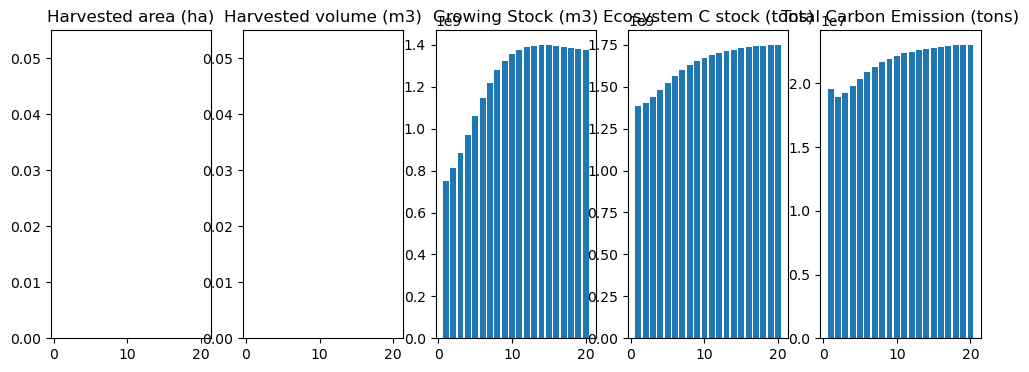

In [97]:
# k_solid_wood = math.log(2) / 30
# k_paper = math.log(2) / 2
run_scenario(fm,'base')

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 812 rows, 45499 columns and 542731 nonzeros
Model fingerprint: 0xb012610c
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 333 rows and 330 columns
Presolve time: 0.25s
Presolved: 479 rows, 45170 columns, 498762 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.717e+04
 Factor NZ  : 2.2

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

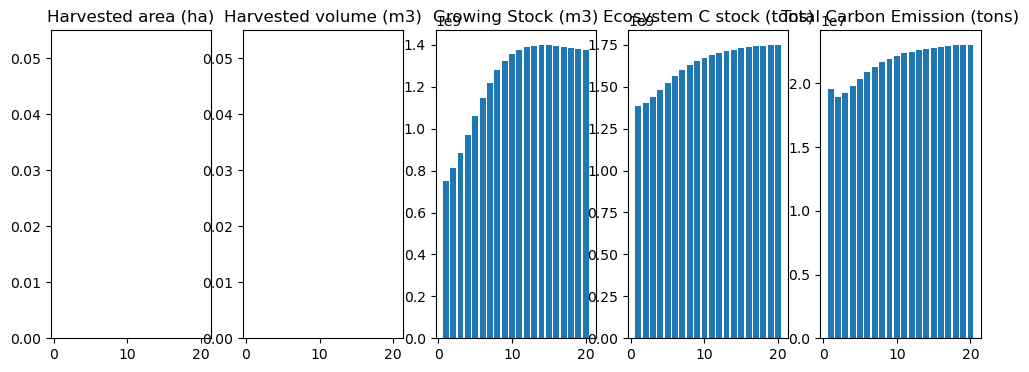

In [58]:
# k_solid_wood = 1
# k_paper = 1
run_scenario(fm,'base')

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 812 rows, 45499 columns and 542731 nonzeros
Model fingerprint: 0xb012610c
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 333 rows and 330 columns
Presolve time: 0.30s
Presolved: 479 rows, 45170 columns, 498762 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.717e+04
 Factor NZ  : 2.2

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.381789e+09  1.954011e+07
 1        2  0.0  0.0  8.124675e+08  1.402196e+09  1.894992e+07
 2        3  0.0  0.0  8.861458e+08  1.436742e+09  1.921555e+07
 3        4  0.0  0.0  9.707337e+08  1.478353e+09  1.975706e+07
 4        5  0.0  0.0  1.060630e+09  1.521575e+09  2.033804e+07
 5        6  0.0  0.0  1.146251e+09  1.561899e+09  2.085700e+07
 6        7  0.0  0.0  1.219698e+09  1.597082e+09  2.128955e+07
 7        8  0.0  0.0  1.278276e+09  1.626686e+09  2.164259e+07
 8        9  0.0  0.0  1.322490e+09  1.651037e+09  2.192896e+07
 9       10  0.0  0.0  1.354309e+09  1.670935e+09  2.216033e+07
 10      11  0.0  0.0  1.376027e+09  1.687321e+09  2.234828e+07
 11      12  0.0  0.0  1.389710e+09  1.700760e+09  2.250060e+07
 12      13  0.0  0.0  1.397148e+09  1.711820e+09  2.262491e+07
 13      14  0.0  0.0  1.399821e+09  1.721052e+09  2.272777e+07
 14

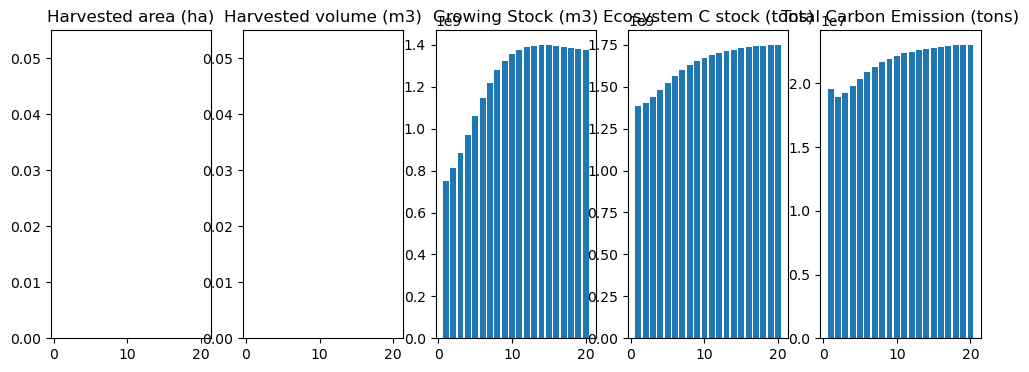

In [58]:
k_solid_wood = 0
k_paper = 0
run_scenario(fm,'base')

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 812 rows, 45499 columns and 542731 nonzeros
Model fingerprint: 0xa9b9aa6b
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [7e+03, 8e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 333 rows and 330 columns
Presolve time: 0.29s
Presolved: 479 rows, 45170 columns, 498762 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.717e+04
 Factor NZ  : 2.2

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  420220.298103  8.754687e+07  6.464084e+08  1.353950e+09   
 1        2  441231.313008  8.036632e+07  6.137830e+08  1.326950e+09   
 2        3  399209.283198  1.065470e+08  5.582925e+08  1.308081e+09   
 3        4  399209.283198  8.010329e+07  5.429915e+08  1.295397e+09   
 4        5  399209.283198  7.530110e+07  5.353777e+08  1.280775e+09   
 5        6  399209.283198  6.115366e+07  5.396916e+08  1.266855e+09   
 6        7  399209.283198  6.036878e+07  5.434599e+08  1.266065e+09   
 7        8  399209.283198  5.030794e+07  5.615556e+08  1.276724e+09   
 8        9  399209.283198  2.112194e+07  6.131900e+08  1.297174e+09   
 9       10  399209.283198  9.576028e+06  6.752612e+08  1.321006e+09   
 10      11  441231.313008  1.552936e+08  5.578676e+08  1.295278e+09   
 11      12  441231.313008  1.215933e+08  4.763643e+08  1.268063e+09   
 12      13  441231.313008 

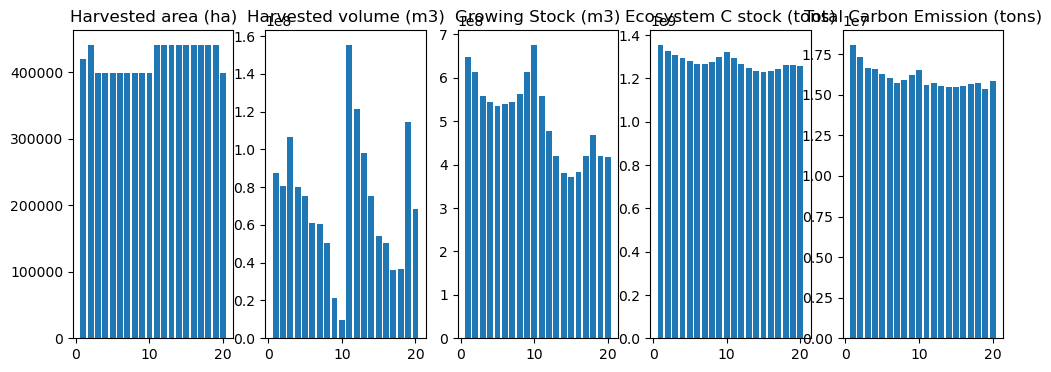

In [58]:
run_scenario(fm,'base')

In [ ]:
run_scenario(fm,'base')

In [ ]:
run_scenario(fm,'base')

In [ ]:
run_scenario(fm,'base')

In [ ]:
run_scenario(fm,'base')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Havrest Volume with Harvesting and Growing Stock Constraints

In [ ]:
run_scenario(fm,'base_h')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

The Carbon Outputs from ws3 and libcbm still looks good when maxmizing the harvest volum from the forest

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Total Ecosystem Carbon Storage without Any Constraints

In [ ]:
# Maximize Total Ecosystem Carbon Storage
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

There will be the least harvesting activities if the target is to maxmize the total ecosystem carbon stock

## Maximize Total Ecosystem Carbon Storage with Harvesting and Growing Stock Constraints

In [ ]:
# Maximize Total Ecosystem Carbon Storage with Minimum and Maximum Harvest  Level and Total Growing Stock Constraints
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Minimize Total Carbon Emissions without Any Constrations

There will be the least harvesting activities if the target is to maxmize the total ecosystem carbon stock

In [ ]:
# Minimize Total Carbon Emissions
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Minimize Total Carbon Emissions with Harvesting and Growing Stock Constraints

In [ ]:
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Total Ecosystem Carbon Sequestration without Constraints

In [ ]:
# Maxmize Total Ecosystem Carbon Sequestration with Havrest and Growing Stock Constraints
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [ ]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

## Maximize Total Ecosystem Carbon Sequestration with Harvesting and Growing Stock Constraints

In [ ]:
# Maxmize Total Ecosystem Carbon Sequestration with Havrest and Growing Stock Constraints
run_scenario(fm,'base_c')

In [ ]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [ ]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)